# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

**Содержание**<a id='toc0_'></a>    
- 1. [Подготовка данных](#toc1_)    
- 2. [Обучение моделей](#toc2_)    
  - 2.1. [Дерево решений](#toc2_1_)    
  - 2.2. [Случайный лес](#toc2_2_)    
  - 2.3. [Градиентный бустинг](#toc2_3_)    
- 3. [Анализ моделей](#toc3_)    
- 4. [Общий вывод](#toc4_)    
- 5. [Чек-лист проверки](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Подготовка данных](#toc0_)

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import mean_squared_error as mse

import lightgbm as lgb

Загрузим и изучим данные.

In [2]:
df_raw = pd.read_csv('/datasets/autos.csv')

In [3]:
df_raw.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df_raw.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
df_raw.duplicated().sum()

4

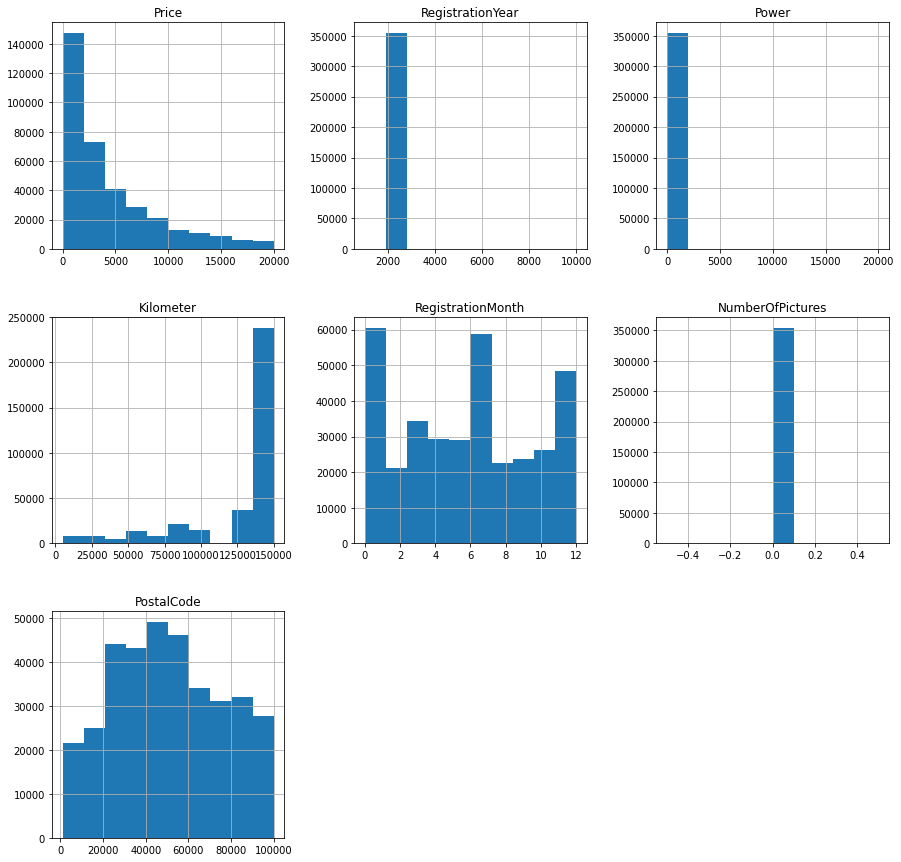

In [7]:
df_raw.hist(figsize=(15, 15));

In [8]:
df_raw.NumberOfPictures.sum()

0

Датасет содержит 16 столбцов и ок. 350_000 строк. Несколько столбцов не имеют отношения к цене автомобиля: DateCrawled — дата скачивания анкеты из базы, DateCreated — дата создания анкеты, PostalCode — почтовый индекс владельца анкеты (пользователя),
LastSeen — дата последней активности пользователя. Столбец NumberOfPictures — количество фотографий автомобиля — не содержит данных. Удалим все эти столбцы.

In [9]:
df = df_raw.drop(columns=['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


Удалим дубликаты

In [11]:
df = df.drop_duplicates()

В некоторых столбцах присутствуют аномалии: мощность двигателя (вряд ли может быть более 1000 л.с.), год регистрации меньше 1900 и больше 2016 (год скачивания базы), цена меньше 100 евро (13314 строк). Все эти данные необходимо удалить.

Стоит отметить, в датасете 40_000 машин с нулевой мощностью. Среди них могут быть те, в которых нет двигателя. Эти данные не удаляем.

In [12]:
df = df.drop(df.query('Power > 1000 or 1900 > RegistrationYear > 2016 or Price < 100').index).reset_index(drop=True)

Помимо самого возраста автомобиля добавим столбец "тип возраста".

In [13]:
df['AgeType'] = pd.cut(df.RegistrationYear, [1900, 1960, 1980, 2000, 2020],
                       labels=['super_retro', 'retro', 'old', 'new'])

Отделим целевой признак от остальных

In [14]:
features = df.drop(columns=['Price'])
target = df['Price']

Разделим данные на обучающую и тестовую выборки

In [15]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=23456)

Для дальнейшей обработки данных будем использовать pipeline.

Для категориальных признаков заполним пропуски значением `undefined` (пропуски есть только в категориальных признаках) и применим порядковое кодирование.

Для числовых признаков необходимо примении масштабирование.

In [16]:
num_features = features.select_dtypes(include=['int64']).columns
cat_features = features.select_dtypes(include=['object']).columns


for f_ in cat_features:
    df[f_] = df[f_].astype('category')

In [17]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
    ('encoder', OrdinalEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', cat_transformer, cat_features)
])

**Вывод по разделу 1:**
- Данные изучены, удалены дубликаты и аномалии
- Подготовлены обучающая и тестовая выборки
- Для дальнейшего обучения моделей подготовлен пайплайн предобработки входных данных

## 2. <a id='toc2_'></a>[Обучение моделей](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Дерево решений](#toc0_)

Первоначально обучим модель дерева решений. Подбор гиперпараметров проведём с помощью `GridSearchCV`

In [18]:
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', DecisionTreeRegressor(random_state=3643))
])

In [ ]:
%%time
params = {
    'model__max_depth' : [4, 8, 12, 20],
    'model__min_samples_leaf' : [1, 4, 8, 12]
}

grid = GridSearchCV(pipeline, params, scoring='neg_root_mean_squared_error', cv=3, verbose=3, n_jobs=-1)
grid.fit(features_train, target_train);

In [20]:
print('Значение RMSE, время обучения и время оценки и при различных гиперпараметрах:')
print(pd.DataFrame(grid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('\nЛучшие гиперпараметры:\n', grid.best_params_)
print('Лучшее значение RMSE:', -grid.best_score_)

Значение RMSE, время обучения и время оценки и при различных гиперпараметрах:
    mean_test_score  mean_fit_time  mean_score_time
0      -2679.061622       0.532548         0.148089
1      -2679.061622       0.500301         0.136476
2      -2679.061622       0.527089         0.159067
3      -2679.061622       0.516799         0.147073
4      -2154.537769       0.719748         0.158888
5      -2155.424746       0.758063         0.157083
6      -2155.232696       0.684166         0.160762
7      -2155.927673       0.725047         0.171535
8      -2007.603172       0.842674         0.158968
9      -1981.806209       0.755426         0.156301
10     -1968.494979       0.816411         0.161906
11     -1963.501217       0.769838         0.146332
12     -2230.187192       1.050887         0.153997
13     -2000.653311       0.979014         0.159164
14     -1927.652026       0.928198         0.153808
15     -1911.885106       0.889523         0.148147

Лучшие гиперпараметры:
 {'model__max_

Лучшее значение RMSE (1911) достигается при `max_depth` = 20, `min_samples_leaf` = 12. Время обучения: 0.85 сек., предсказания: 0.13 сек.

### 2.2. <a id='toc2_2_'></a>[Случайный лес](#toc0_)

Теперь обучим модель случайного леса, используя гиперпараметры лучшего решающего дерева.

In [21]:
params = {
    'model__n_estimators' : [20, 50, 70],
    'model__max_depth' : [20],
    'model__min_samples_leaf' : [12],
    'model' : [RandomForestRegressor(random_state=3643)]
}

rf_grid = GridSearchCV(pipeline, params, scoring='neg_root_mean_squared_error', cv=2, verbose=3, n_jobs=-1)

In [ ]:
%%time
rf_grid.fit(features_train, target_train);

In [23]:
print('Значение RMSE, время обучения и время оценки и при различных гиперпараметрах:')
print(pd.DataFrame(rf_grid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('\nЛучшие гиперпараметры:\n', rf_grid.best_params_)
print('Лучшее значение RMSE:', -rf_grid.best_score_)

Значение RMSE, время обучения и время оценки и при различных гиперпараметрах:
   mean_test_score  mean_fit_time  mean_score_time
0     -1806.846586       5.482743         0.573756
1     -1799.412621      13.483535         1.210292
2     -1798.497537      18.455868         1.525086

Лучшие гиперпараметры:
 {'model': RandomForestRegressor(max_depth=20, min_samples_leaf=12, n_estimators=70,
                      random_state=3643), 'model__max_depth': 20, 'model__min_samples_leaf': 12, 'model__n_estimators': 70}
Лучшее значение RMSE: 1798.497536927326


Как оказалось, обучать более 50 деревьев почти не имеет смысла: уменьшение метрики - незначительное, время обучения - кратно возрастает.

Поэтому будем считать оптимальными такие гиперпараметры: `max_depth` = 20; `min_samples_leaf` = 12; `n_estimators` = 50. Примерное время обучения одной модели - 13.5 секунд, время предсказания - 1.2 сек., RMSE = 1799.

Использование данной модели снижает метрику RMSE на 120 единиц, при этом время обучения вырастает в десятки раз.

### 2.3. <a id='toc2_3_'></a>[Градиентный бустинг](#toc0_)

Для подбора гиперпараметров модели градиентного бустинга сначала попробуем использовать `GridSearchCV`.

In [ ]:
%%time
params = {"model__max_depth": [12],
          "model__boosting_type" : ['gbdt', 'dart'],
          "model__min_child_samples" : [20],
          "model__learning_rate" : [0.15, 0.3, 0.45],
          "model__num_leaves": [31, 70],
          "model__n_estimators" : [50],
          "model" : [lgb.LGBMRegressor(random_state=654566)]}

lgbm_grid = GridSearchCV(pipeline, params, scoring='neg_root_mean_squared_error', cv=2, verbose=3, n_jobs=-1)
lgbm_grid.fit(features_train, target_train);

In [25]:
print('Значение RMSE, время обучения и время оценки и при различных гиперпараметрах:')
print(pd.DataFrame(lgbm_grid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('\nЛучшие гиперпараметры:\n', lgbm_grid.best_params_)
print('Лучшее значение RMSE:', -lgbm_grid.best_score_)

Значение RMSE, время обучения и время оценки и при различных гиперпараметрах:
    mean_test_score  mean_fit_time  mean_score_time
0      -1786.040889     126.812185         0.799577
1      -1722.892178     360.119648         0.979755
2      -1745.438643     123.149299         0.735221
3      -1697.381299      29.194211         0.756972
4      -1744.999128      33.348377         0.641968
5      -1718.666196      28.790616         0.704407
6      -2029.706543      33.546449         0.693212
7      -1934.761349      41.946193         0.804762
8      -1813.544614      30.899997         0.706575
9      -1748.461828     179.540160         0.851039
10     -1762.072881      29.298250         0.699045
11     -1707.094102     361.216759         0.898213

Лучшие гиперпараметры:
 {'model': LGBMRegressor(learning_rate=0.3, max_depth=12, n_estimators=50, num_leaves=70,
              random_state=654566), 'model__boosting_type': 'gbdt', 'model__learning_rate': 0.3, 'model__max_depth': 12, 'model__min

Для сокращения времени подбора гиперпараметров, попробуем использовать `HalvingGridSearchCV` - поиск по заданным значениям параметров с последовательным делением пополам.
<br>В качестве ресурса оставим значение по умолчанию — количество сэмплов для обучения модели.

In [26]:
%%time
params = {"model__max_depth": [12],
          "model__boosting_type" : ['gbdt', 'dart'],
          "model__min_child_samples" : [20],
          "model__learning_rate" : [0.1, 0.15, 0.3],
          "model__num_leaves": [31, 70, 100],
          "model__n_estimators" : [50],
          "model" : [lgb.LGBMRegressor(random_state=654566)]}

lgbm_hgrid  = HalvingGridSearchCV(pipeline, params, scoring='neg_root_mean_squared_error',
                                  cv=3, verbose=3, n_jobs=-1, min_resources=200, factor=3)
lgbm_hgrid.fit(features_train, target_train);

print('Значения RMSE при различных гиперпараметрах:')
print(pd.DataFrame(lgbm_hgrid.cv_results_)[['params', 'mean_test_score']])
print('\nЛучшие гиперпараметры:\n', lgbm_hgrid.best_params_)
print('Лучшее значение RMSE:', -lgbm_hgrid.best_score_) 

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 7
min_resources_: 200
max_resources_: 251805
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 200
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END model=LGBMRegressor(random_state=654566), model__boosting_type=gbdt, model__learning_rate=0.1, model__max_depth=12, model__min_child_samples=20, model__n_estimators=50, model__num_leaves=31; total time=   6.1s
[CV 2/3] END model=LGBMRegressor(random_state=654566), model__boosting_type=gbdt, model__learning_rate=0.1, model__max_depth=12, model__min_child_samples=20, model__n_estimators=50, model__num_leaves=31; total time=  25.5s
[CV 3/3] END model=LGBMRegressor(random_state=654566), model__boosting_type=gbdt, model__learning_rate=0.1, model__max_depth=12, model__min_child_samples=20, model__n_estimators=50, model__num_leaves=31; total time=   3.8s
[CV 1/3] END model=LGBMRegressor(random_state=654566), model__boosti

Описанный выше метод даёт некачественные результаты, поэтому изменим тип ресурса на количество обучаемых деревьев.

In [27]:
%%time

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor(random_state=654566))
])

params = {"model__max_depth": [12], 
          "model__boosting_type" : ['gbdt', 'dart'],
          "model__min_child_samples" : [12, 20],
          "model__learning_rate" : [0.1, 0.3, 0.4],
          "model__num_leaves": [31, 100, 150]}

lgbm_hgrid  = HalvingGridSearchCV(pipeline, params, scoring='neg_root_mean_squared_error',
                                  cv=2, verbose=3, n_jobs=-1, max_resources=150, factor=3,
                                  resource='model__n_estimators')
lgbm_hgrid.fit(features_train, target_train);

print('Значение RMSE, время обучения и время оценки и при различных гиперпараметрах:')
print(pd.DataFrame(lgbm_hgrid.cv_results_)[['mean_test_score', 'mean_fit_time', 'mean_score_time']])
print('\nЛучшие гиперпараметры:\n', lgbm_hgrid.best_params_)
print('Лучшее значение RMSE:', -lgbm_hgrid.best_score_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 5
max_resources_: 150
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 5
Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END model__boosting_type=gbdt, model__learning_rate=0.1, model__max_depth=12, model__min_child_samples=12, model__n_estimators=5, model__num_leaves=31; total time=   2.3s
[CV 2/2] END model__boosting_type=gbdt, model__learning_rate=0.1, model__max_depth=12, model__min_child_samples=12, model__n_estimators=5, model__num_leaves=31; total time=   2.9s
[CV 1/2] END model__boosting_type=gbdt, model__learning_rate=0.1, model__max_depth=12, model__min_child_samples=12, model__n_estimators=5, model__num_leaves=100; total time=   3.7s
[CV 2/2] END model__boosting_type=gbdt, model__learning_rate=0.1, model__max_depth=12, model__min_child_samples=12, model__n_estimators=5, model__num_leaves=100; total time=   5.9s
[CV 1/2] END model__bo

In [31]:
pd.DataFrame(lgbm_hgrid.cv_results_)\
    [['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time' ]]\
    .tail(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time
52,96.352630,5.044418,1.968684,0.051276
53,86.995665,7.825249,1.818125,0.015985


**Вывод по разделу 2:**
- Изучены модели решающего дерева, случайного леса и градиентного бустинга (библиотека LightGBM) при различных гиперпараметрах
- Лучше всего себя показал градиентный бустинг: наименьшие значение целевой метрики (RMSE = 1670), время обучения (ок. 10 сек) и время предсказания
- Гиперпараметры лучшей модели: `boosting_type`: 'gbdt', `learning_rate`: 0.3, `max_depth`: 12, `min_child_samples`: 20, `num_leaves`: 150, `n_estimators`: 135)

## 3. <a id='toc3_'></a>[Анализ моделей](#toc0_)

Проверим качество лучшей модели на тестовой выборке, предварительно обучив её на всей "трейн-валидационной" выборке с наиболее оптимальными гиперпараметрами. Также рассмотрим значение метрики R2.

In [28]:
%%time
lgbm_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', lgb.LGBMRegressor(boosting_type='gbdt', learning_rate=0.3, max_depth=12,
                                min_child_samples=20, num_leaves=150, n_estimators=135, random_state=3643))
])

lgbm_pipeline.fit(features_train, target_train)
rmse = mse(target_test, lgbm_pipeline.predict(features_test)) ** 0.5
r2 = lgbm_pipeline.score(features_test, target_test)

print(f'Значения метрик на тестовой выборке: RMSE = {rmse}, R2 = {r2}')

Значения метрик на тестовой выборке: RMSE = 1636.5579188859724, R2 = 0.8694151231545456
CPU times: user 1min 59s, sys: 1.12 s, total: 2min
Wall time: 2min 1s


Время обучения модели составляет примерно 96 секунд, предсказания и оценки - около 2 секунд. Достигнуто значение RMSE, равное 1636.

Рассмотрим важность различных факторов, основываясь на итоговой модели.

<AxesSubplot:>

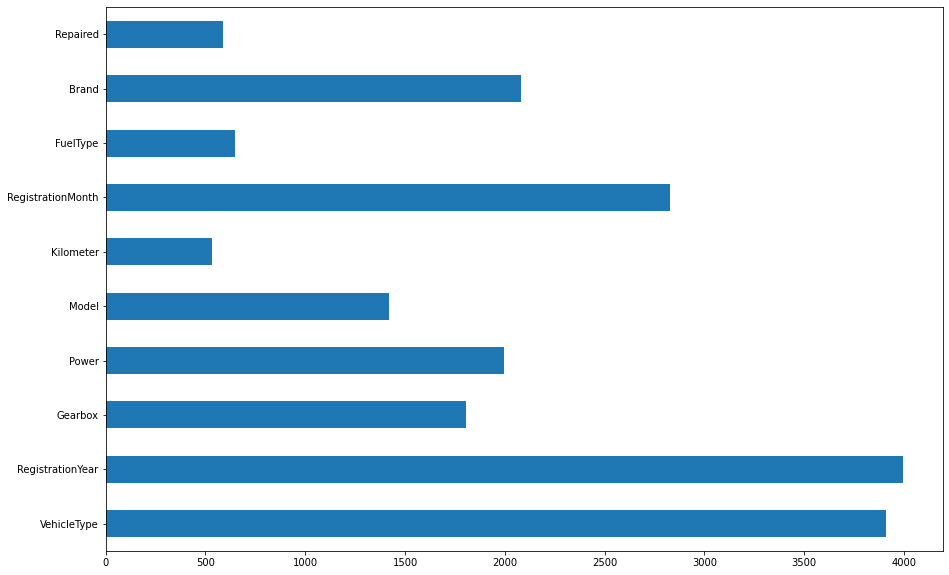

In [32]:
pd.Series(lgbm_pipeline.named_steps['model'].feature_importances_, index=features_train.columns[:-1])\
            .plot(kind='barh', figsize=(15, 10))

Важнейшие факторы при определении цены авто: тип кузова, год и месяц регистрации

## 4. <a id='toc4_'></a>[Общий вывод](#toc0_)

- Данные изучены, подготовлены обучающая и тестовая выборки, для обучения моделей подготовлен пайплайн предобработки входных данных
- Обучены модели решающего дерева, случайного леса и градиентного бустинга (библиотека LightGBM) при различных гиперпараметрах
- Лучше всего себя показал градиентный бустинг: значение целевой метрики **RMSE = 1636, время обучения = 2 мин**
- Гиперпараметры лучшей модели: `boosting_type`: 'gbdt', `learning_rate`: 0.3, `max_depth`: 12, `min_child_samples`: 20, `num_leaves`: 150, `n_estimators`: 135)

## 5. <a id='toc5_'></a>[Чек-лист проверки](#toc0_)

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей